<font size=6>**DL Regression**</font> </h6>

In this session we provide a short introduction to **Regression**, a topic which can be covered by both machine learning applications (such as those in [scikit-learn](https://scikit-learn.org/stable/index.html) we saw in clustering and classification session) and deep learning approaches. <br>
The goals are:

- to get an idea of how we **build and train** a deep learning model
- explore some **basic concepts** to better understand their use and impact. 

In the example that will follow we are mainly going through these steps:

    1. Load and Select Data
    2. Define Model
    3. Compile Model
    4. Fit Model 
    5. Iterate steps 2-3-4 (by adjusting various parameters or the model architecture)
    6. Evaluate Model
    7. Make Predictions


# What is regression ?

    Modeling problems where the output is a continuous numeric value.


# Linear regression and least squares

A linear regression model will try to predict the single value of the dependent variable $y$ given the independent variable $x$, with the most generic form being: 

$$y = f (x | β), $$

where $x$ corresponds to the input variable(s) and $β$ is an array of parameters.

The simplest linear model we can think of is a line:

$$y = β_0 + β_1 x $$

where $β_0$ and $β_1$ have the usual meaning of intercept and slope of a line. 

Generalizing a bit, for an input vector $x^T = (x_1, x_2, ..., x_N)$,  where $N$ is the total number of observations (or samples), the linear model to predict the real-valued output $y$ is:

$$ f(x) = β_0 + \sum_{i=1}^{N} x_i β_i. $$

To find these parameters we use the Ordinary Least Squares approach, i.e. we try to **minimize** the residual sum of the squares between the observations and the predictions by the model (i.e. the **loss or cost** function):

$$ RSS(β) = \sum_{i=1}^{N} (y_i - f(x_i))^2 =  \sum_{i=1}^{N} (y_i - β_0 - x_i β_i)^2 .$$




# The more general linear regression

Linear regression refers to modeling functions that are linear with respect to the parameters (coefficients) and not with respect to the variables! For example, the function:

$$f (x|β) = \sum_{i=1}^N β_i g_i(x) = β_1 g_1(x) + β_2 g_2(x)~+~...~+~β_N g_N(x) $$

describes a linear problem as long as the sub-functions $g_i(x)$ do not depend on any of the parameters $β_i$. This is not the most generic formulation of the linear regression but we are going to use this form in the following applications.

# On metrics ... or how well can we do

> _Accuracy is a measure for classification not regression_<br>
> _We cannot calculate accuracy for a regression model_
>
>  _by Jason Brownlee [Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)_

In regression we are dealing with continuous values. Therefore, it is actually impossible to predict the exact same values. The idea is to get an estimate of how close the predictions are to the expected values.

We are going to refer only a few of the available metrics in [sklearn](https://machinelearningmastery.com/regression-metrics-for-machine-learning/). In the following $y$ refers to the dependent values while $\hat{y}$ to the predicted values.

**--> Mean Squared Error (MSE)**

$$ MSE = \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2 $$  

It is actually the cost function of the Ordinary Least Squares (check $RSS(β)$ above). The units returned in this case are squared. Best score is 0.

**--> Root Mean Squared Error (RMSE)**

$$ RMSE = \sqrt{ \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2 } $$  

It returns the square root of MSE so that the units match the units of the target value (so better interpretation).  Best score is 0.

**--> Mean Absolute Error (MAE)**

$$ MAE = {1 \over N}\sum_i^N{|  y_i-\hat{y_i} |}$$  

It is less sensitive to large errors when compared to (R)MSE. The score is in units of the target value and the best 

> Comment: Although arithetically the best scores for (R)MSE and MAE is 0 this cannot be the case in real-life problems. Instead a baseline model has to be determined and calculate its score. Then, any model that can achieve a score better that the baselie model is accepted as a skilful model.  


**--> R2 (coefficient of determination)**

$$R^2 = 1 - {\sum_{i=1}^N{(y_i-\hat{y_i})^2} \over \sum_{i=1}^N{(y_i - \bar{y})^2}}, $$ 

where $\bar{y} = \frac{1}{n}\sum_{i=1}^N y_i$. 

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 


# Application 1: Estimate SFR

We will use data derived from the Heraklion Extragalactic Catalogue (HECATE; [Kovlakas et al, 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.506.1896K/abstract)) which is an all-sky galaxy catalogue, containing about 200k galaxies (up to z=0.047, D≲200Mpc), and it offers positions, sizes, distances, morphological classifications, star formation rates, stellar masses, metallicities, and nuclear activity classifications. 

In particular, we are going to use a dataset from the work of [Kouroumpatzakis et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...673A..16K/abstract) where they estimate the Star Formation Rates (SFR) and stellar mass using model Spectral Enerny Distributions with a variaty of parameters (optical and IR photometry, color terms, and stellar populations). 

**TASK: build a regression model to predict SFR**


<font size=4>**CHALLENGE**:</font> </h4>   <br> 
    
They used MCMC and Random Forest, so your work is to build a DL model that will **outperform their results**!!! <br>

**Can we ?**
<br>
<br>

<center><img src="images/yoda_meme.jpg"></center>



&#9755; Sometimes Validation and Test samples can be used interchangeable - as soon as it is clear what is what (and that a real separate unseen sample is used)

In [1]:
# Loading packages and defining some functions

import numpy as np
import matplotlib.pyplot as plt
import time
import keras
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization,Conv3D, MaxPooling3D, Dense, Add, Activation
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    # NOTE: the current version can print only the first metric from the list provided
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.losses2.append(logs.get( test_metrics[0] ) )
        self.val_losses2.append(logs.get( f'val_{test_metrics[0]}' ))
#         print(test_metrics[0] , logs.get( test_metrics[0] ), logs.get( f'val_{test_metrics[0]}' ))
#         print(self.losses2)

        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses2, label="Train",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Validate",linestyle='--')
#        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel(test_metrics[0])
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, label="Train",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Validate",linestyle='--')

        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        
        plt.show();
        
plot_losses = PlotLosses()


def sub_ploots(plots_cols, plots_array):
        """ Automatic adjustment of subplots
        Given the 
        plots_cols     : plots per row (set manually)
        plots_array    : array from which the number of 
                         individual subplots is derived

        the output is given as 
        plots_cols     : plots per row
        plots_rows     : number of necessary rows to create
        """
        plots_unique = len((list(set(plots_array))))
        plots_rows = int(np.ceil(plots_unique/plots_cols))
        
        return plots_rows, plots_cols

Using TensorFlow backend.
/home/grigoris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/grigoris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/grigoris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/grigoris/.local/lib/python3.7/site-packages/tensorflo

## Loading and checking data 

In [2]:
from astropy.io import fits
from astropy.table import Table
# following this tutorial :https://learn.astropy.org/tutorials/FITS-tables.html

data_fits = fits.open('data/CIGALE_SFR.fits', memmap=True)

# printing some information 
data_fits.info()
print('-----')
print(data_fits[1].columns)

Filename: data/CIGALE_SFR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1149,)   uint8   
  1  /home/grigoris/Projects/AstroStatisticsCrete-2023/notebooks/CIGAL...    1 BinTableHDU     46   123908R x 17C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
-----
ColDefs(
    name = 'sfr'; format = 'D'
    name = 'mstar'; format = 'D'
    name = 'IRX'; format = 'D'
    name = 'IRXg'; format = 'D'
    name = 'EBVs'; format = 'D'
    name = 'EBVn'; format = 'D'
    name = 'MTLCT'; format = 'D'
    name = 'LYoungOld'; format = 'D'
    name = 'u'; format = 'D'
    name = 'g'; format = 'D'
    name = 'r'; format = 'D'
    name = 'logNIR200'; format = 'D'
    name = 'logMIRI2100'; format = 'D'
    name = 'logW1'; format = 'D'
    name = 'logW2'; format = 'D'
    name = 'logW3'; format = 'D'
    name = 'logW4'; format = 'D'
)


In [3]:
# printing the data table 

data_tab = Table(data_fits[1].data)
data_tab

sfr,mstar,IRX,IRXg,EBVs,EBVn,MTLCT,LYoungOld,u,g,r,logNIR200,logMIRI2100,logW1,logW2,logW3,logW4
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1.7775958737441702,8.88439002050874,1.0597066442746876,0.6514418848431899,0.075,0.25,0.004,-1.161582684412036,-25.165328563337408,-25.70599046191616,-26.291299528344705,20.57568201275021,20.915356290620906,20.283857754272237,20.07785242628705,20.749168886908052,20.977838069609653
-5.598150103513504,7.163475768985803,0.6090525930420546,0.15809224130840754,0.075,0.25,0.0004,-3.095438541121911,-20.778258821449963,-21.42565970078408,-22.134851538101163,18.699843670803883,18.71021154983641,18.380386821972536,18.169375587980156,18.556209527608885,18.77235612162204
0.46026919969367264,9.555252512015649,1.902715602377176,1.6737613712475208,0.12,0.4,0.0004,-0.007993003792127648,-27.381645133910272,-27.474030711734407,-28.06240482059499,21.24489484510881,22.644248708956212,21.234736799549726,21.25041706188928,22.46532446497027,22.707373655941282
2.4145309631249785,10.32453156040969,1.399250989811699,1.4079612806413735,0.06,0.2,0.05,0.59695867241776,-32.76388688802393,-32.26211116094975,-32.80171050240841,23.240506755171285,24.305480238065996,23.0619764044172,23.01596122061309,24.127836105292985,24.356805745021273
-3.2602550268517,8.694262138626932,1.5825219675250681,1.1352159457468731,0.24,0.8,0.008,-2.6966069354956685,-24.52041935307027,-25.158684407515764,-25.82528302865342,20.478382255352365,21.17948475308555,20.222128818087356,20.063940269851575,21.003583359324065,21.242689708753176
-3.8229180838972106,8.827694847737332,0.794228535480207,0.2843246519908631,0.06,0.2,0.0004,-2.6499464090799667,-23.653879827467303,-24.44863953619066,-25.365224425817953,20.175890232692996,20.04636052688319,19.85353655051953,19.621751170933265,19.900476164368083,20.10778046646713
0.8506413438533907,9.465027116409965,1.6451465950450486,1.4984204145555122,0.12,0.4,0.02,0.42176281956076034,-28.549734687420038,-28.43655013864388,-28.793100027358232,21.583159957555335,22.862224270730703,21.464771982664036,21.462010041607755,22.70072019878477,22.917040470013063
0.3212462542445377,8.46334364974829,1.9219557531126592,1.7177592328383302,0.195,0.65,0.008,1.943541695128508,-26.299831693555685,-26.3303229942415,-26.67930205973931,20.53529154234542,22.23356572282868,20.641662695014567,20.73772356328627,22.06708673225438,22.29388843053493
0.34317898627799476,8.287711611276643,1.9519193931772922,1.8290439645016736,0.18,0.6,0.0004,0.38600979614344816,-26.790091534343144,-26.61728010603219,-26.97489956389519,20.545438547880376,22.456827133479848,20.8170107257701,20.952689859912386,22.277083741941293,22.519956006914548


## Selecting features

In this part we can select which features we want to keep and use to train our model. Feel free to choose any number of feature - keep in mind though **NOT** to select `sfr` and `mstar` as these are needed for the output (i.e. are the values we want to predict).

_HINT_: for the column names check above.

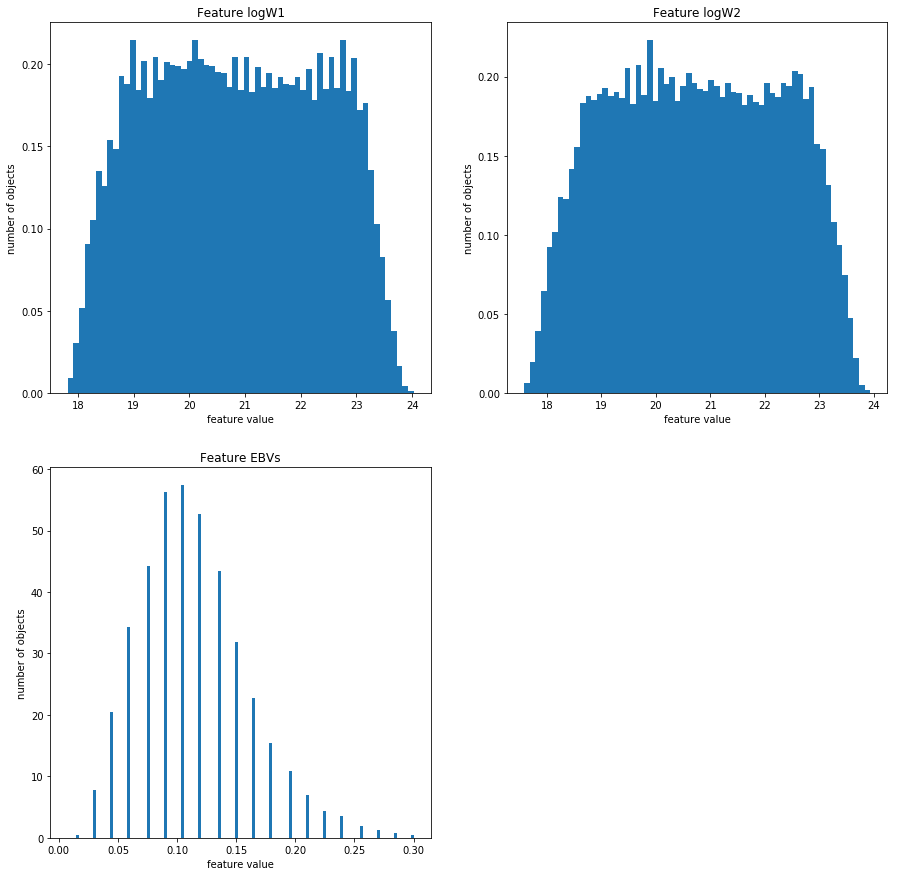

In [81]:
sel_features = ['logW1', 'logW2', 'EBVs' ]

fig = plt.figure(figsize=(15,15))

rws, cls = sub_ploots(2, sel_features)  # for subplots
for f in range(len(sel_features)):
    f_name = sel_features[f]
    ax = fig.add_subplot(rws, cls, f+1)
    ax.set_title(f'Feature {f_name}')
    ax.hist(data_tab[f_name], bins='auto', align='mid', density=True)
    ax.set_xlabel('feature value')
    ax.set_ylabel('number of objects')
    
plt.show()

and the data table looks like ...

In [82]:
data_tab[sel_features]


logW1,logW2,EBVs
float64,float64,float64
20.283857754272237,20.07785242628705,0.075
18.380386821972536,18.169375587980156,0.075
21.234736799549726,21.25041706188928,0.12
23.0619764044172,23.01596122061309,0.06
20.222128818087356,20.063940269851575,0.24
19.85353655051953,19.621751170933265,0.06
21.464771982664036,21.462010041607755,0.12
20.641662695014567,20.73772356328627,0.195
20.8170107257701,20.952689859912386,0.18


In [83]:
# converting table objects to numpy arrays

values = data_tab[sel_features].as_array()
values = values.view((float, len(values.dtype.names)))
target = np.array(data_tab['sfr']).reshape(-1,1)

print('The values for selected features:')
print(values)
print()
print('The target quantity:')
print(target)


The values for selected features:
[[20.28385775 20.07785243  0.075     ]
 [18.38038682 18.16937559  0.075     ]
 [21.2347368  21.25041706  0.12      ]
 ...
 [19.36443306 19.15993578  0.045     ]
 [22.41655641 22.24424336  0.075     ]
 [20.33383818 20.35995967  0.165     ]]

The target quantity:
[[-1.77759587]
 [-5.5981501 ]
 [ 0.4602692 ]
 ...
 [-2.56037601]
 [-1.62659848]
 [-0.28624628]]


## Split the sample and ... ?

**TASK: what should you do before training the model?**

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_full, X_test, y_train_full, y_test = train_test_split( values, target,
                        test_size=0.3) #, random_state=42) 
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full,
                        test_size=0.2) #, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print(f'> From {len(target)} sources:')
print(f'   {len(X_train)} (train)')
print(f'   {len(X_valid)} (validation)')
print(f'   {len(X_test)} (test)') 
print('\n> Statistics per feature:')
print(f'Mean: {scaler.mean_}')
print(f'Variance: {scaler.var_}')
print()
print(f' Target shape: {y_train.shape}') # print the shape of the output values


> From 123908 sources:
   69388 (train)
   17347 (validation)
   37173 (test)

> Statistics per feature:
Mean: [20.8452147  20.73948873  0.11399096]
Variance: [2.27205497e+00 2.32831919e+00 2.14053172e-03]

 Target shape: (69388, 1)


## Time to build our model! 

In [85]:
# if you want you can add more output metrics!
# but keep in mind that the plot_losses will use the first one.

test_metrics = [ 'mean_squared_error'] #, 'mean_absolute_error', ]


In [86]:
model = Sequential()

model.add( Dense(32, input_shape=X_train_full.shape[1:], activation='relu') )
model.add( Dense(16, activation='relu') )
model.add( Dense(1) )

In [87]:
optzr = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optzr, metrics = test_metrics)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


## Finally ... train the model!

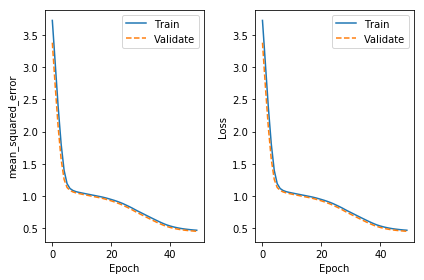

'00:01:01'

In [88]:
start_time = time.time() 

history=model.fit(X_train_scaled, y_train, 
                    batch_size=512, 
                    epochs=50,
                    validation_data=[ X_valid_scaled, y_valid],
                    callbacks=[plot_losses],shuffle=True)

# to print history contents
# history.history
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

## ... and the moment of truth - evaluation

_HINT_: remember at which set we evaluate our model to

In [89]:
evaluation = model.evaluate(X_test_scaled, y_test)
print(f"Loss value: {evaluation[0]:.2f}")  
for m in range(len(test_metrics)):
    print(f"{test_metrics[m]}: {evaluation[m+1]:0.2f}")  
    
y_pred = model.predict( X_test_scaled)    

37173/37173 [==============================] - 1s 20us/step
Loss value: 0.47
mean_squared_error: 0.47


## Checking the predicitons

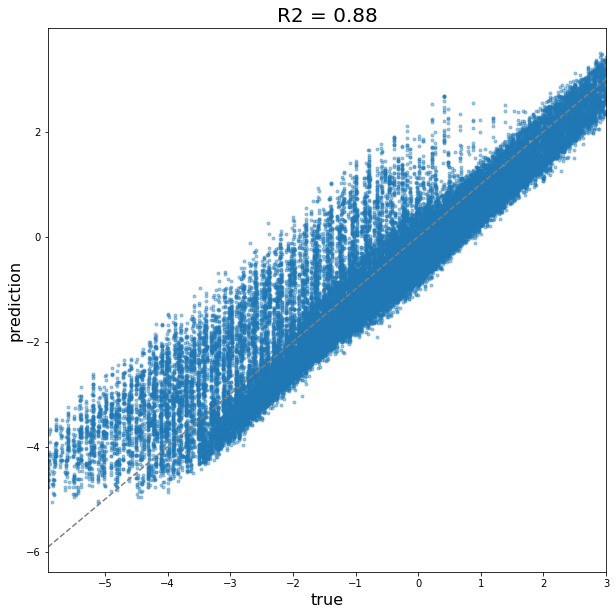

In [90]:
from sklearn.metrics import r2_score

fig = plt.figure(figsize=(10,10))

r2 = r2_score( y_test , y_pred)

min_ax, max_ax = np.min(y_test), np.max(y_test)
    
plt.plot(y_test, y_pred, '.', alpha=0.4)
plt.title( f'R2 = {r2:0.2f}', fontsize=20)
plt.xlabel('true', fontsize=16)
plt.ylabel('prediction', fontsize=16)
plt.xlim([min_ax, max_ax])

# 1-to-1 line:
xx = np.linspace(min_ax, max_ax, 100)
plt.plot(xx, xx, c="grey", linestyle='--')

plt.show()

## Comparing with paper results! Is it better ???

Comparing your results with Fig 3 by [Kouroumpatzakis et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...673A..16K/abstract), where the ratio of the predictions over true SFR values are plotted with true SFR values.

In [115]:
res[:,0]

array([-5.91195715, -5.91195715, -5.91195715, ...,  2.99838083,
        2.99992368,  2.99992368])

/home/grigoris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


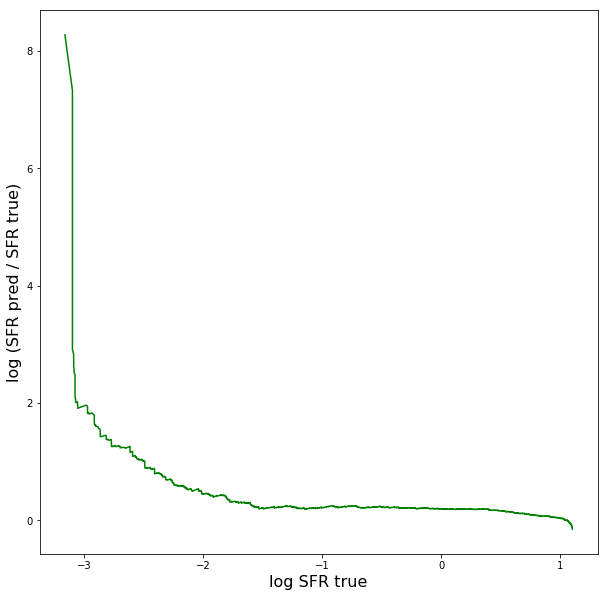

In [119]:
# converting data to 2d and sorting 
arr = np.concatenate( (y_test, y_pred), axis=1 )
res = np.sort(arr, axis = 0)       

fig = plt.figure(figsize=(10,10))

objs = np.arange(len(res))

plt.plot( np.log(res[:,0]), np.log( res[:,0]/res[:,1]), '-g')
plt.xlabel('log SFR true', fontsize=16)
plt.ylabel('log (SFR pred / SFR true)', fontsize=16)

plt.show()


<center><img src="images/Kouroumpatzakis2023-Fig3.png"> 
Figure 5.1. Figure 3 from   <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...673A..16K/abstract" target="_blank" rel="noopener noreferrer">Kouroumpatzakis et al. (2023)</a> presenting the omparison between the true SFR as given by the CIGALE output (data used), and the best-fit models of MCMC, and the Random Forest.</center>

_**Question**: So... did you manage to do better ?_

_HINT_: the resulted range should be smaller...


# Application 2: Estimate SFR and stellar mass

In this case we want to use all/part of the available features to estimate both the SFR (`sfr`) **and** the stellar mass (`mstar`). 

For this we need to adjust the number of output nodes and the shape of the data. 

**TASK 1: adjust the model to train and predict both values**

**TASK 2: use a custom loss function**

In [73]:
# select data 

sel_features = ['logW1', 'logW2', 'EBVs' ]
pre_features = ['sfr', 'mstar']

values = data_tab[sel_features].as_array()
values = values.view((float, len(values.dtype.names)))

target = data_tab[pre_features].as_array()
target = target.view((float, len(target.dtype.names)))


print('The values for selected features:')
print(values)
print()
print('The target quantity:')
print(target)


The values for selected features:
[[20.28385775 20.07785243  0.075     ]
 [18.38038682 18.16937559  0.075     ]
 [21.2347368  21.25041706  0.12      ]
 ...
 [19.36443306 19.15993578  0.045     ]
 [22.41655641 22.24424336  0.075     ]
 [20.33383818 20.35995967  0.165     ]]

The target quantity:
[[-1.77759587  8.88439002]
 [-5.5981501   7.16347577]
 [ 0.4602692   9.55525251]
 ...
 [-2.56037601  8.2272979 ]
 [-1.62659848 11.23385302]
 [-0.28624628  8.25822978]]


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_full, X_test, y_train_full, y_test = train_test_split( values, target,
                        test_size=0.3) #, random_state=42) 
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full,
                        test_size=0.2) #, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print(f'> From {len(target)} sources:')
print(f'   {len(X_train)} (train)')
print(f'   {len(X_valid)} (validation)')
print(f'   {len(X_test)} (test)') 
print('\n> Statistics per feature:')
print(f'Mean: {scaler.mean_}')
print(f'Variance: {scaler.var_}')
print()
print(f' Target shape: {y_train.shape}') # print the shape of the output values


> From 123908 sources:
   69388 (train)
   17347 (validation)
   37173 (test)

> Statistics per feature:
Mean: [20.84016112 20.73436015  0.11445542]
Variance: [2.2721526e+00 2.3277834e+00 2.1640720e-03]

 Target shape: (69388, 2)


The function below defines an example of loss function. 

In [57]:
import keras.backend as K

def custom_mse(y_true, y_pred):
 
    # calculating squared difference between target and predicted values 
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    print(loss)
    
    # multiplying the values with weights along batch dimension
    loss = loss * [0.5, 0.5]          # (batch_size, 2)
    print(loss)  
    # summing both loss values along batch dimension 
    loss = K.sum(loss, axis=1)        # (batch_size,)
    print(loss)
    return loss

# if ypu want to add more output metrics
# test_metrics = [ 'mean_absolute_error', 'mean_squared_error']
test_metrics = [ 'mean_squared_error'] #, 'mean_absolute_error', ]


In [58]:
model = Sequential()

model.add( Dense(32, input_shape=X_train.shape[1:], activation='relu') )
model.add( Dense(16, activation='relu') )
model.add( Dense(2) )

In [59]:
optzr =  Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optzr, metrics = test_metrics)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


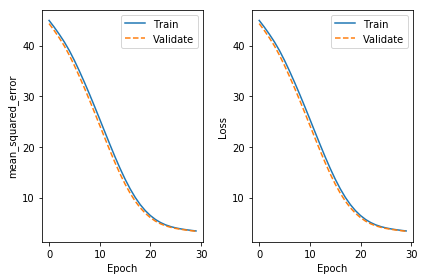

'00:00:42'

In [60]:
start_time = time.time() 

history=model.fit(X_train_scaled, y_train, 
                    batch_size=1024, 
                    epochs=30,
                    validation_data=[ X_valid_scaled, y_valid],
                    callbacks=[plot_losses],shuffle=True)

# to print history contents
# history.history
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

37173/37173 [==============================] - 2s 51us/step
Loss value: 3.34
mean_squared_error: 3.34
------


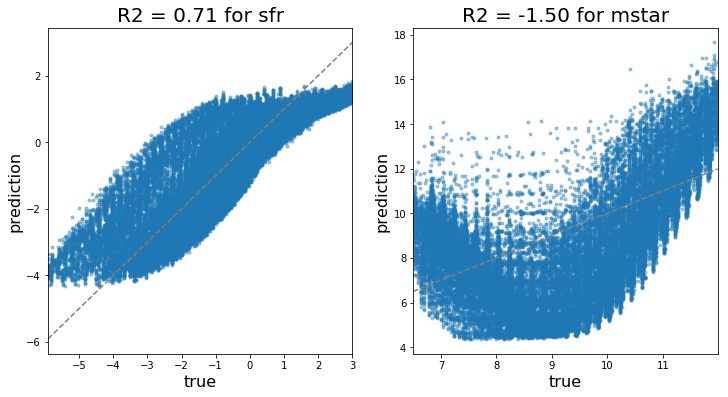

In [77]:
evaluation = model.evaluate(X_test_scaled, y_test)
print(f"Loss value: {evaluation[0]:.2f}")  
for m in range(len(test_metrics)):
    print(f"{test_metrics[m]}: {evaluation[m+1]:0.2f}")  

print('------')

y_pred = model.predict( X_test_scaled) 

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes = axes.flatten()

for i, ax in enumerate(axes):
  
    r2 = r2_score( y_test[:,i] , y_pred[:,i])
    
    min_ax, max_ax = np.min(y_test[:,i]), np.max(y_test[:,i])

    ax.plot(y_test[:,i], y_pred[:,i], '.', alpha=0.4)
    ax.set_title( f'R2 = {r2:0.2f} for {pre_features[i]}', fontsize=20)
    ax.set_xlabel('true', fontsize=16)
    ax.set_ylabel('prediction', fontsize=16)
    ax.set_xlim([min_ax, max_ax])

    min_ax, max_ax = np.min(y_test[:,i]), np.max(y_test[:,i])
    # 1-to-1 line:
    xx = np.linspace(min_ax, max_ax, 100)
    ax.plot(xx, xx, c="grey", linestyle='--')
    

plt.show()

_**Question**: What do you notice here ?_

<br>
<details>
<summary>Click for answer</summary>
We may get some decent result for SFR but the predictions for mstar are not that good Additional information and features are needed (possibly distance should be added). 
</details>
